# 📊 Exploratory Data Visualization for Customer Insights  
### Math for Machine Learning — Linear Algebra Applications

This notebook explores three related datasets—**Customer Demographics**, **Customer Transactions**, and **Social Media Interactions**—to visualize key patterns and relationships that form the foundation for linear algebra–based analysis.

The goal of this notebook is to **understand the structure of our data matrices** before applying machine learning or dimensionality reduction techniques like **Principal Component Analysis (PCA)** or **Singular Value Decomposition (SVD)**.  
Each dataset represents a different view of the same population:

1. **Demographics Dataset:** Contains personal attributes such as age, gender, income level, and signup date.  
   - Focus: Distributions, group comparisons, and trends over time.  

2. **Transactions Dataset:** Records spending behavior, product categories, and payment methods.  
   - Focus: Revenue distribution, customer concentration (Pareto analysis), and PCA for spending patterns.  

3. **Social Interactions Dataset:** Captures engagement across platforms and sentiment.  
   - Focus: Sentiment analysis, activity trends, and PCA on engagement styles.  

Throughout this notebook, we apply **core Linear Algebra principles** to data exploration:
- Representing datasets as **matrices**, where rows correspond to customers and columns correspond to features or interaction types.  
- Using **correlation matrices** to identify linear relationships between numerical features.  
- Applying **PCA** and **SVD** to find dominant directions of variance—revealing hidden structures in customer behavior.

Each visualization below is crafted to **bridge data analysis with mathematical intuition**, helping us understand not just what the data shows, but how its structure can be described and manipulated algebraically.  
Let’s begin exploring these datasets and see how mathematics translates into real-world insights!

## A) DEMOGRAPHICS — distributions & groups

In [2]:
# DEMO-SETUP
import pandas as pd, numpy as np, matplotlib.pyplot as plt

demo = pd.read_csv("cleaned_customer_demographics.csv")
demo["signup_date"] = pd.to_datetime(demo["signup_date"], errors="coerce")

print(demo.dtypes)
print(demo.head(3))

customer_id             object
age                    float64
gender                  object
location                object
income_level            object
signup_date     datetime64[ns]
dtype: object
                            customer_id   age  gender    location  \
0  9207fa75-5758-48d1-94ad-19c041e0520f  51.0  Female  Jensenberg   
1  50118139-7264-428f-81cc-a25fddc5d6dd  44.0    Male   Port Carl   
2  7d1f2bbc-8d16-4fbc-9b37-ece3324e8ed4  50.0  Female   Jessebury   

  income_level signup_date  
0          Low  2022-11-17  
1       Medium  2024-06-10  
2         High  2023-08-24  


### A1. Age distribution (skew/spread)

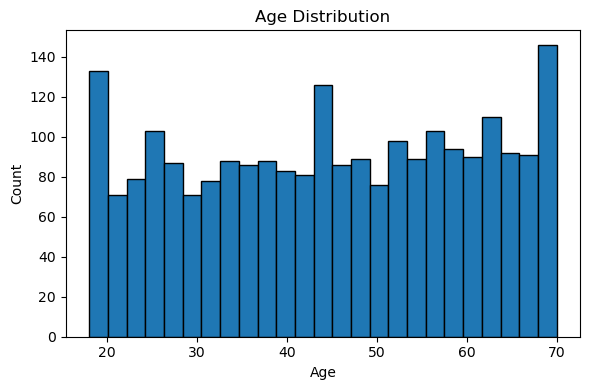

In [3]:
plt.figure(figsize=(6,4))
demo["age"].plot(kind="hist", bins=25, edgecolor="black")
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout(); plt.show()

### A2. Age by gender (boxplot)

C:\Users\nicol\AppData\Local\Temp\ipykernel_6204\1659904656.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


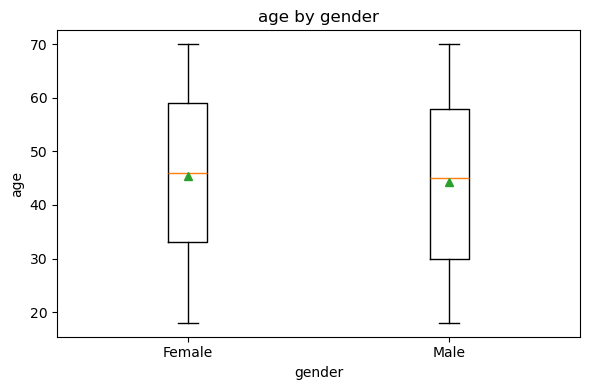

In [4]:
def box_by_group(df, value_col, group_col):
    data = [g[value_col].dropna().values for _, g in df.groupby(group_col)]
    labels = [str(x) for x in df[group_col].dropna().unique()]
    plt.figure(figsize=(6,4))
    plt.boxplot(data, labels=labels, showmeans=True)
    plt.title(f"{value_col} by {group_col}")
    plt.xlabel(group_col); plt.ylabel(value_col)
    plt.tight_layout(); plt.show()

if "gender" in demo.columns:
    box_by_group(demo, "age", "gender")

### A3. Income & Gender counts (bar charts)

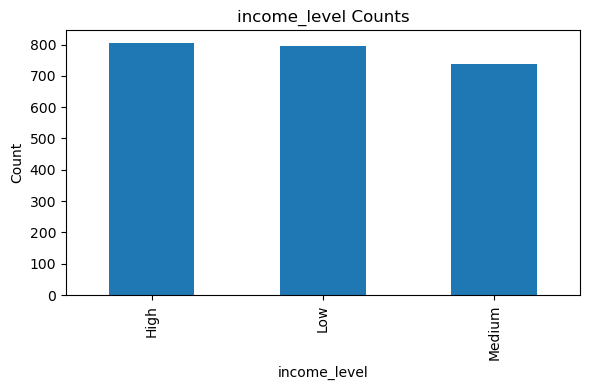

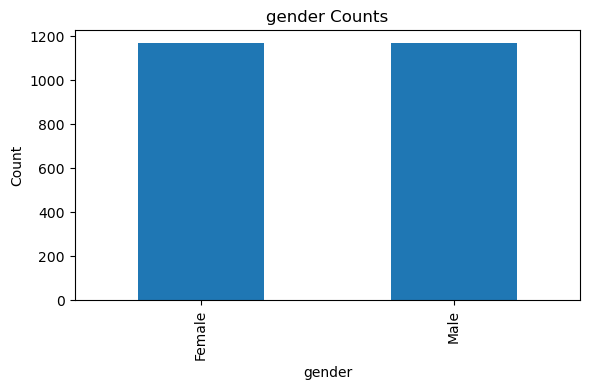

In [5]:
for col in ["income_level", "gender"]:
    if col in demo.columns:
        plt.figure(figsize=(6,4))
        demo[col].value_counts(dropna=False).plot(kind="bar")
        plt.title(f"{col} Counts")
        plt.xlabel(col); plt.ylabel("Count")
        plt.tight_layout(); plt.show()

### A4. Heatmap: Gender × Income cross-tab

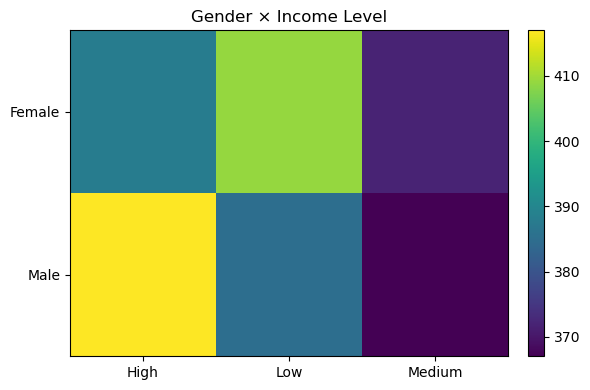

In [6]:
import numpy as np

if set(["gender","income_level"]).issubset(demo.columns):
    ct = pd.crosstab(demo["gender"], demo["income_level"])
    plt.figure(figsize=(6,4))
    im = plt.imshow(ct.values, aspect="auto")
    plt.title("Gender × Income Level")
    plt.xticks(range(ct.shape[1]), ct.columns, rotation=0)
    plt.yticks(range(ct.shape[0]), ct.index)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
    ct

### A5. Signup trend (monthly new customers)

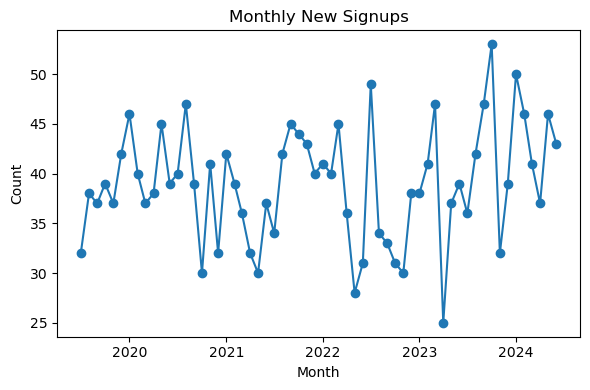

In [7]:
if "signup_date" in demo.columns:
    monthly = demo.set_index("signup_date").resample("MS")["customer_id"].count()
    plt.figure(figsize=(6,4))
    plt.plot(monthly.index, monthly.values, marker="o")
    plt.title("Monthly New Signups")
    plt.xlabel("Month"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

## B) TRANSACTIONS — revenue, categories, Pareto, PCA on preferences

In [9]:
txn = pd.read_csv("cleaned_customer_transactions.csv")
txn["transaction_date"] = pd.to_datetime(txn["transaction_date"], errors="coerce")

print(txn.dtypes)
print(txn.head(3))

customer_id                 object
transaction_id              object
transaction_date    datetime64[ns]
amount                     float64
product_category            object
payment_method              object
is_refund                     bool
dtype: object
                            customer_id                        transaction_id  \
0  60567026-f719-4cd6-849e-137e86d8938f  5ff75116-0a50-4d04-80fb-31e5ccbb0769   
1  4090ba85-b111-4f75-a792-c777965f5255  2c39b9fe-ff57-4d39-9321-9f5cdf187aa1   
2  9223891b-73ff-4d5c-b8ae-13ece82ee28b  f79588dd-3db9-4ffa-97f8-7de0e64259f1   

  transaction_date  amount product_category payment_method  is_refund  
0       2024-05-15  117.64         Clothing         Paypal      False  
1       2023-04-26  466.14  Health & Beauty  Bank Transfer      False  
2       2022-09-23  563.99         Clothing     Debit Card      False  


### B1. Distribution of transaction amounts

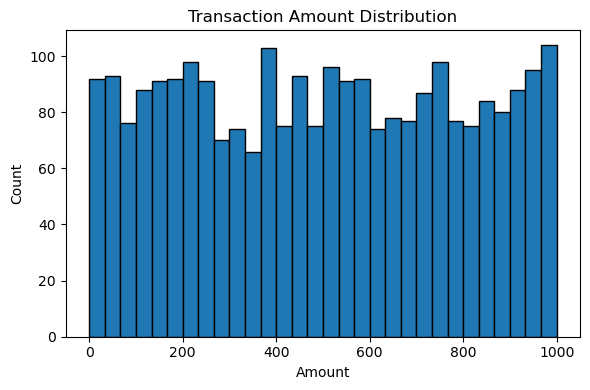

In [10]:
plt.figure(figsize=(6,4))
txn["amount"].plot(kind="hist", bins=30, edgecolor="black")
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

### B2. Revenue over time (exclude refunds)

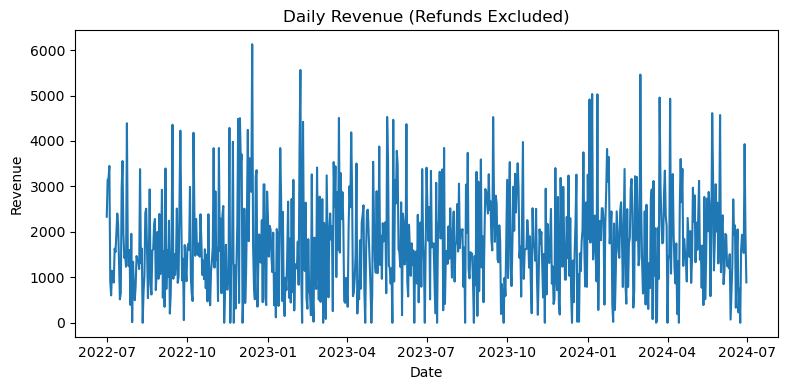

In [11]:
rev = txn[~txn["is_refund"]].set_index("transaction_date").resample("D")["amount"].sum()

plt.figure(figsize=(8,4))
plt.plot(rev.index, rev.values)
plt.title("Daily Revenue (Refunds Excluded)")
plt.xlabel("Date"); plt.ylabel("Revenue")
plt.tight_layout(); plt.show()

### B3. Boxplots by product category & payment method

C:\Users\nicol\AppData\Local\Temp\ipykernel_6204\1688336882.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(x) for x in order], showmeans=True)


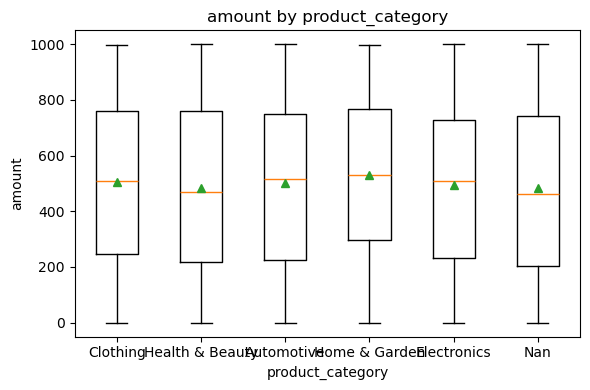

C:\Users\nicol\AppData\Local\Temp\ipykernel_6204\1688336882.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(x) for x in order], showmeans=True)


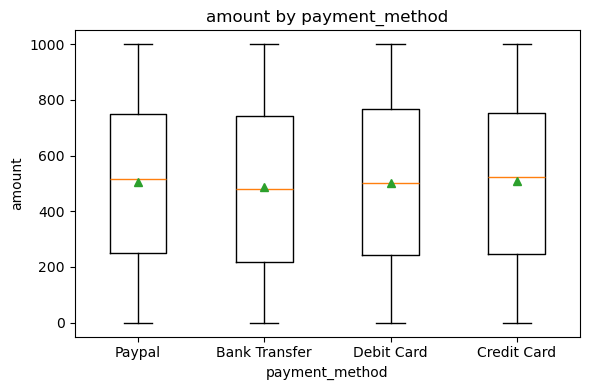

In [12]:
def box_by_group_txn(df, value_col, group_col):
    if group_col not in df.columns: return
    order = df[group_col].dropna().unique()
    data = [df.loc[df[group_col]==g, value_col].dropna().values for g in order]
    plt.figure(figsize=(6,4))
    plt.boxplot(data, labels=[str(x) for x in order], showmeans=True)
    plt.title(f"{value_col} by {group_col}")
    plt.xlabel(group_col); plt.ylabel(value_col)
    plt.tight_layout(); plt.show()

box_by_group_txn(txn, "amount", "product_category")
box_by_group_txn(txn, "amount", "payment_method")

### B4. Refund rate by product category (bar)

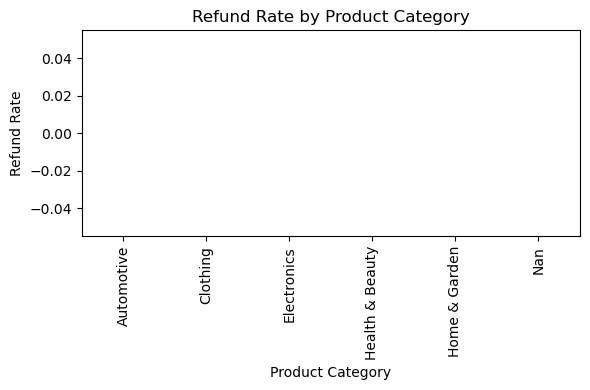

In [14]:
if "product_category" in txn.columns:
    rr = txn.groupby("product_category")["is_refund"].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    rr.plot(kind="bar")
    plt.title("Refund Rate by Product Category")
    plt.xlabel("Product Category"); plt.ylabel("Refund Rate")
    plt.tight_layout(); plt.show()


### B5. Pareto curve (customer concentration of revenue)

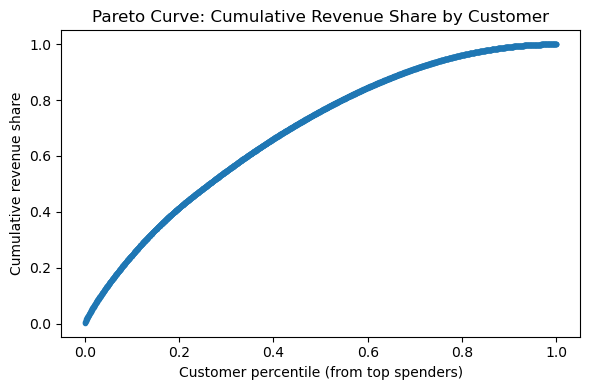

Share of revenue from top 20% customers: 0.41434308573120315


In [15]:
cust_rev = txn[~txn["is_refund"]].groupby("customer_id")["amount"].sum().sort_values(ascending=False)
cum_share = cust_rev.cumsum() / cust_rev.sum()
x = np.arange(1, len(cust_rev)+1) / len(cust_rev)

plt.figure(figsize=(6,4))
plt.plot(x, cum_share.values, marker=".")
plt.title("Pareto Curve: Cumulative Revenue Share by Customer")
plt.xlabel("Customer percentile (from top spenders)"); plt.ylabel("Cumulative revenue share")
plt.tight_layout(); plt.show()

print("Share of revenue from top 20% customers:",
      cum_share.iloc[int(0.2*len(cum_share))-1])

### B6. PCA on customer × product_category spend (preference structure)

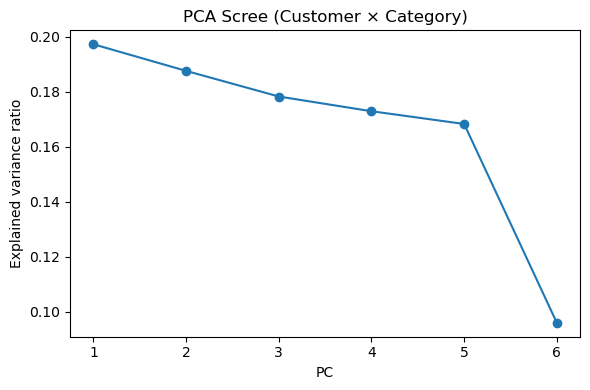

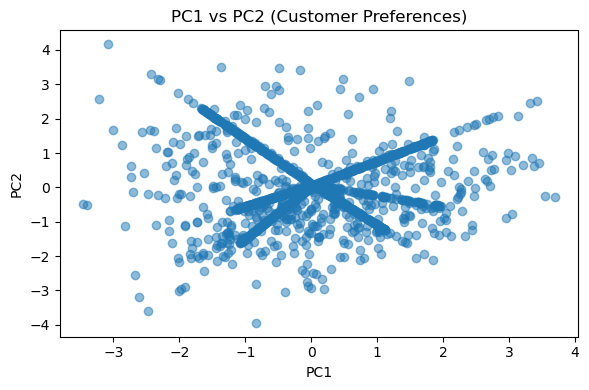

,PC1,PC2,PC3,PC4,PC5,PC6
product_category,,,,,,
Home & Garden,0.540360,0.390107,-0.270053,0.069448,-0.536995,0.435559
Automotive,-0.475865,0.626425,0.306861,-0.132998,0.194827,0.480973
Nan,0.399805,-0.125732,-0.265562,-0.455583,0.658241,0.336134
Clothing,-0.340784,-0.517594,-0.022838,-0.504772,-0.452234,0.395133
Electronics,-0.339091,-0.205105,-0.548243,0.607179,0.171963,0.379660
Health & Beauty,0.301003,-0.360039,0.679185,0.382716,0.079436,0.407057


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Build customer × category matrix (sum of amounts)
mat = txn.pivot_table(index="customer_id", columns="product_category",
                      values="amount", aggfunc="sum", fill_value=0)

# Standardize columns (equalize scales across categories)
scaler = StandardScaler()
Xz = scaler.fit_transform(mat)

# PCA
pca = PCA()
Z = pca.fit_transform(Xz)

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_, marker="o")
plt.title("PCA Scree (Customer × Category)")
plt.xlabel("PC"); plt.ylabel("Explained variance ratio")
plt.tight_layout(); plt.show()

# 2D projection
plt.figure(figsize=(6,4))
plt.scatter(Z[:,0], Z[:,1], alpha=0.5)
plt.title("PC1 vs PC2 (Customer Preferences)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

# Loadings (which categories define PC1)
loadings = pd.DataFrame(pca.components_.T,
                        index=mat.columns,
                        columns=[f"PC{i+1}" for i in range(len(mat.columns))])
loadings.sort_values("PC1", key=np.abs, ascending=False).head(10)

### C) SOCIAL INTERACTIONS — activity, sentiment mix, weekly patterns, PCA

In [17]:
social = pd.read_csv("cleaned_social_media_interactions.csv")
social["interaction_date"] = pd.to_datetime(social["interaction_date"], errors="coerce")

print(social.dtypes)
print(social.head(3))


customer_id                 object
interaction_id              object
interaction_date    datetime64[ns]
platform                    object
interaction_type            object
sentiment                   object
dtype: object
                            customer_id                        interaction_id  \
0  08a911a3-65e6-4f5d-a6a1-ae7ddcbe28a2  a83fa04c-f109-4f24-8ce1-2078154f6a1c   
1  efdfdfc9-5dbb-4478-911a-101a390a0285  28a69c4b-a2e4-4c74-a130-1132d7733fdf   
2  3e44871b-f56c-4576-b1ca-d1dc999e2166  0c409883-8396-48e4-83fb-887329848696   

  interaction_date   platform interaction_type sentiment  
0       2024-05-24  Instagram          Comment   Neutral  
1       2023-11-01  Instagram             Like   Neutral  
2       2023-12-18  Instagram          Comment  Positive  


### C1. Daily interaction volume

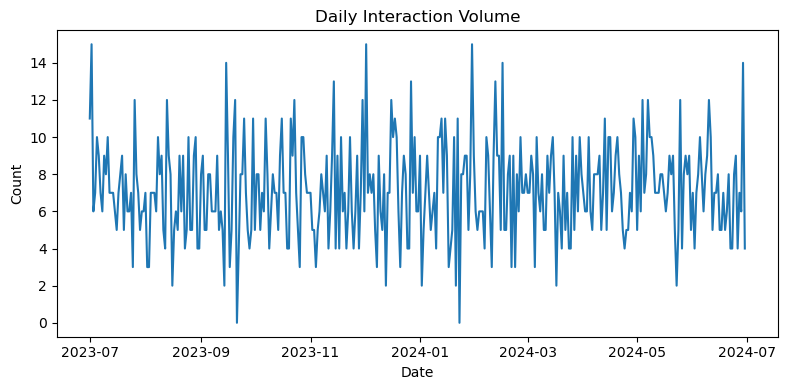

In [18]:
daily = social.set_index("interaction_date")["interaction_id"].resample("D").count()

plt.figure(figsize=(8,4))
plt.plot(daily.index, daily.values)
plt.title("Daily Interaction Volume")
plt.xlabel("Date"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

### C2. Sentiment distribution overall (bar)

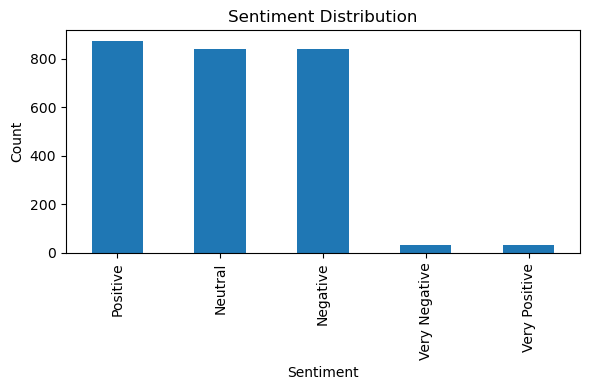

In [19]:
plt.figure(figsize=(6,4))
social["sentiment"].value_counts().plot(kind="bar")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

### C3. Sentiment mix by platform (stacked bars)

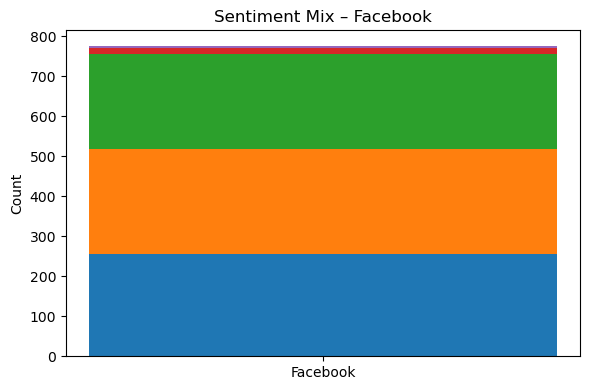

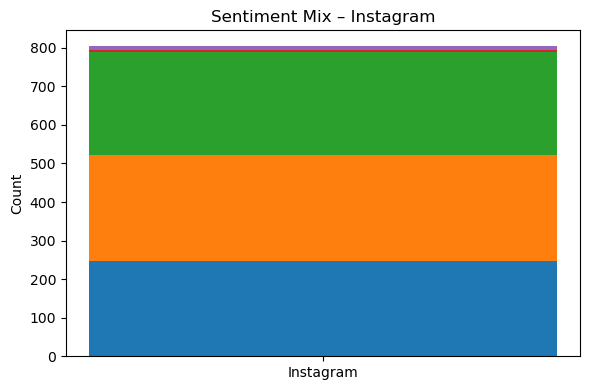

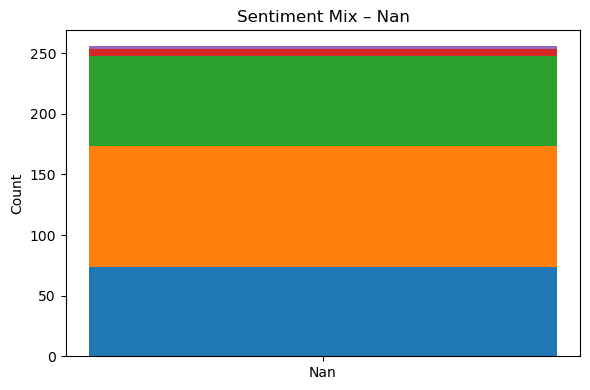

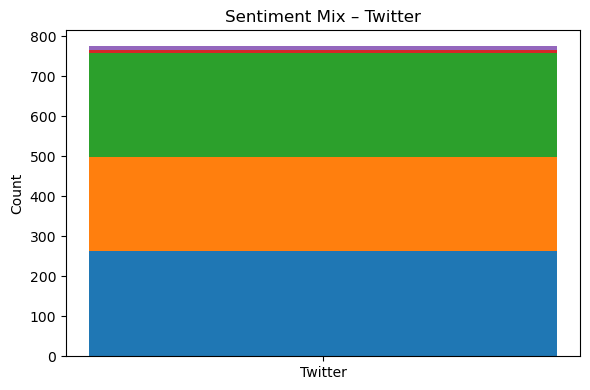

In [20]:
sentiments = social["sentiment"].dropna().unique().tolist()
plat_sent = social.pivot_table(index="platform", columns="sentiment",
                               values="interaction_id", aggfunc="count", fill_value=0)

for plat in plat_sent.index:
    plt.figure(figsize=(6,4))
    bottom = 0
    for s in sentiments:
        val = plat_sent.loc[plat, s] if s in plat_sent.columns else 0
        plt.bar([0], [val], bottom=bottom)
        bottom += val
    plt.xticks([0],[str(plat)])
    plt.title(f"Sentiment Mix – {plat}")
    plt.ylabel("Count")
    plt.tight_layout(); plt.show()

### C4. Activity by weekday

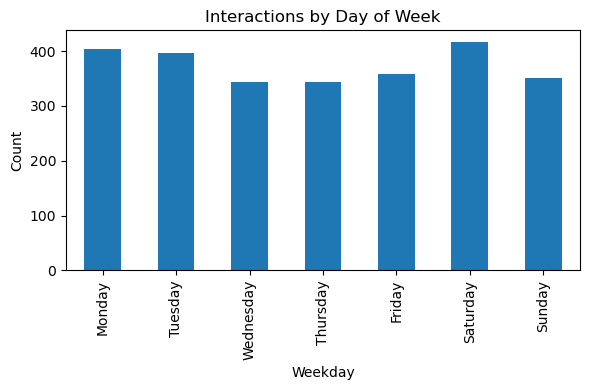

In [21]:
social["weekday"] = social["interaction_date"].dt.day_name()
wk = social["weekday"].value_counts().reindex([
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
])

plt.figure(figsize=(6,4))
wk.plot(kind="bar")
plt.title("Interactions by Day of Week")
plt.xlabel("Weekday"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

### C5. PCA on customer × interaction_type counts (engagement style)

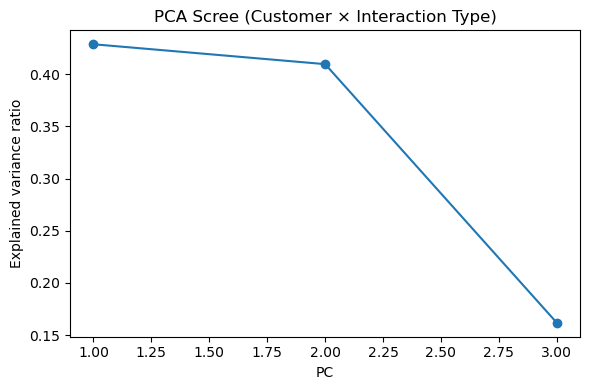

In [ ]:
types = "interaction_type"
cust_type = social.pivot_table(index="customer_id", columns=types,
                               values="interaction_id", aggfunc="count", fill_value=0)

# Standardize across types
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
Xz = scaler.fit_transform(cust_type)

pca = PCA()
Z = pca.fit_transform(Xz)

# Scree
plt.figure(figsize=(6,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_, marker="o")
plt.title("PCA Scree (Customer × Interaction Type)")
plt.xlabel("PC"); plt.ylabel("Explained variance ratio")
plt.tight_layout(); plt.show()

# 2D projection
plt.figure(figsize=(6,4))
plt.scatter(Z[:,0], Z[:,1], alpha=0.5)
plt.title("PC1 vs PC2 (Engagement Styles)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

# Loadings for PC1
load = pd.DataFrame(pca.components_.T,
                    index=cust_type.columns,
                    columns=[f"PC{i+1}" for i in range(cust_type.shape[1])])
load.sort_values("PC1", key=np.abs, ascending=False).head(10)